#  Прогнозирование заказов такси

<a id=0></a>
[Содержание](#0)

[1. Описание проекта](#1)

[2. Анализ данных](#2)

[3. Подготовка данных](#3)

[4. Обучение моделей](#4)

[5. Тестирование модели](#5)

[6. Общий вывод](#6)

<a id=1></a>
## 1. Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Цель проекта:**

Построить модель для прогнозирования количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Данные:**

Данные находятся в файле:
`/datasets/taxi.csv`

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План работы:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.

2. Проанализировать данные, заполнить пропущенные значения.

3. Подготовить выборки для обучения моделей.

4. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

5. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

6. Сделать вывод.

<a id=2></a>
[Содержание](#0)
## 2. Анализ данных

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

RND_STATE = 10032023

Загрузим данные из файла в датафрейм:

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data['num_orders'].unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67])

Отсортируем индекс таблицы и проверим, в хронологическом ли порядке расположены даты и время с помощью атрибута индекса таблицы `is_monotonic`:

In [5]:
data.sort_index(inplace = True)
print(data.index.is_monotonic)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


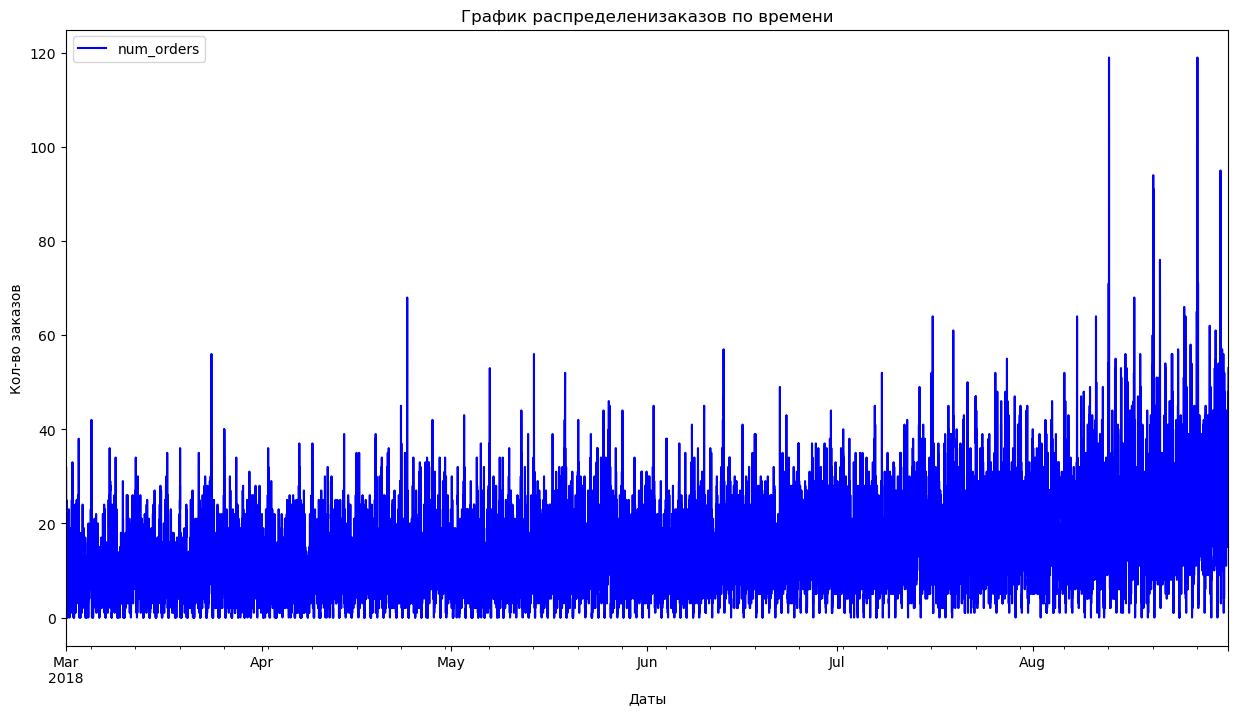

In [6]:
data.plot(figsize = (15, 8), color = 'blue', title = 'График распределенизаказов по времени')
plt.xlabel('Даты')
plt.ylabel('Кол-во заказов')
plt.show()

Выполним ресемплирование данных по одному часу, для агрегации значений используем функцию sum():

In [7]:
data_1h = data.resample('1H').sum()
data_1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data_1h['num_orders'].unique()

array([124,  85,  71,  66,  43,   6,  12,  15,  34,  69,  64,  96,  30,
        32,  48,  44,  73,  45,  61, 113,  58,  90, 120,  75,  20,  11,
         7,  46,  54,  91,  36,  59,  82,  83,  89,  49,  93, 101, 119,
        72, 163, 108,  25,   9,  17,  56,  52,  57,  28,  41,  76,  68,
        63,  60,  26,  42,  27,  22,  39,  19,  51,  80,  77,  86, 176,
        16,   3,  14,  31,  50,  62,  37,  40,  47,  10,  81, 100, 121,
        24,  38,  55,  99, 127,  94, 143,  78,  65,  97, 114,  88,  79,
        84,  29,   1,   4,  70, 117,   5,  18,  53, 102,  33, 107, 118,
       153, 105,  67,  35, 109,  21,   8, 123, 110, 134, 133, 137, 126,
        13,  74,  95, 139,  87, 106,  92, 148, 182, 104, 131,  98,   2,
       112, 103, 128, 166, 111,  23,   0, 129, 164, 165, 138, 142, 159,
       115, 130, 135, 150, 167, 147, 253, 140, 172, 116, 125, 162, 201,
       136, 146, 154, 145, 155, 158, 156, 193, 197, 234, 157, 122, 144,
       149, 171, 152, 174, 186, 132, 194, 183, 188, 229, 173, 18

Напишем функцию для добавления признаков: день недели и час, отстающие значения (lag), скользящее среднее (rolling):

In [9]:
def add_features(df, max_lag, rolling_size):
    
    result = df.copy()
    
    result['wday'] = df.index.dayofweek
    result['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        result['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    result['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    
    return result

Применим функцию к таблице data с размером отставания lag = 2 и с размером окна скользящего среднего rolling = 24, результат сохраним в новый датасет new_data:

In [10]:
new_data = add_features(data_1h, 2, 24)
new_data

,num_orders,wday,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


**Вывод:**

В этом разделе были выполнены следующие задачи:

- Данные прочитаны, в качестве индекса установлен столбец `datetime`.
- Выполнено ресемплирование данных в столбце num_orders по одному часу.
- Созданы новые признаки: календарные признаки (день недели и час), отстающие значения, скользящее среднее.

Данные подготовлены для анализа.

<a id=3></a>
[Содержание](#0)
## 3. Подготовка данных

В исходном датасете данные за полгода - с 1 марта по 31 августа 2018 года. Посмотрим тренд за этот период, а также сезонные изменения в пределах недели и дня. Для удобства дальнейшего анализа данных ресемплируем данные по дням:

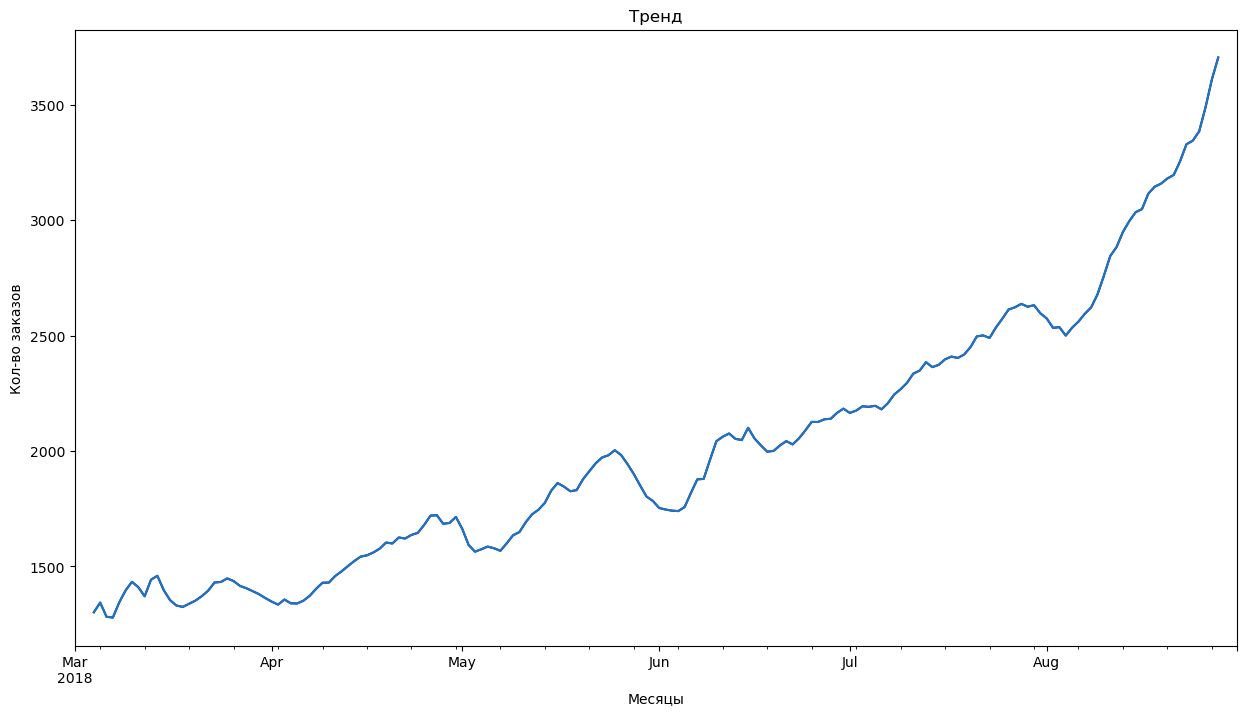

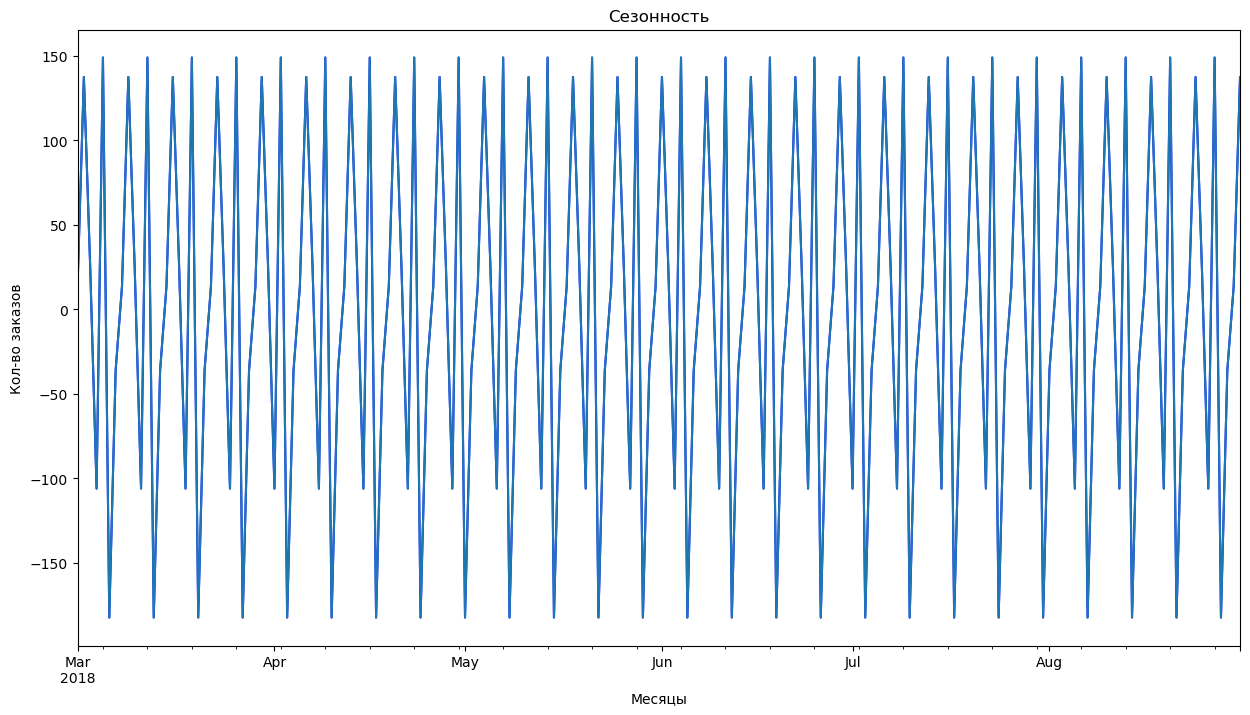

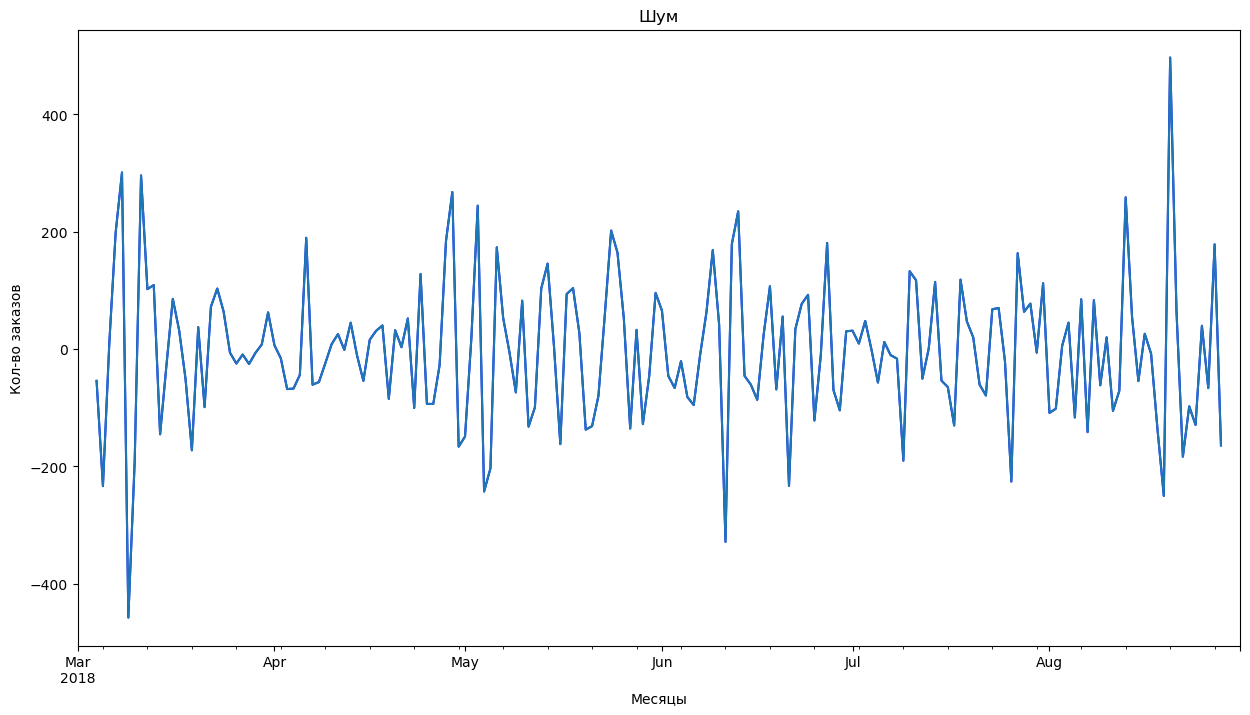

In [11]:
data_180d = seasonal_decompose(data.resample('1D').sum())
data_180d.trend.plot(figsize = (15, 8), color = 'blue')
data_180d.trend.plot(title = 'Тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()
data_180d.seasonal.plot(figsize = (15, 8), color = 'blue')
data_180d.seasonal.plot(title = 'Сезонность')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()
data_180d.resid.plot(figsize = (15, 8), color = 'blue')
data_180d.resid.plot(title = 'Шум')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Кривая тренда показывает уверенный рост числа заказов такси в аэропорт на всем периоде данных.

Кривая сезонности показывает однотипные колебания на всем периоде.

Посмотрим, как изменяется число заказов такси в течение недели:

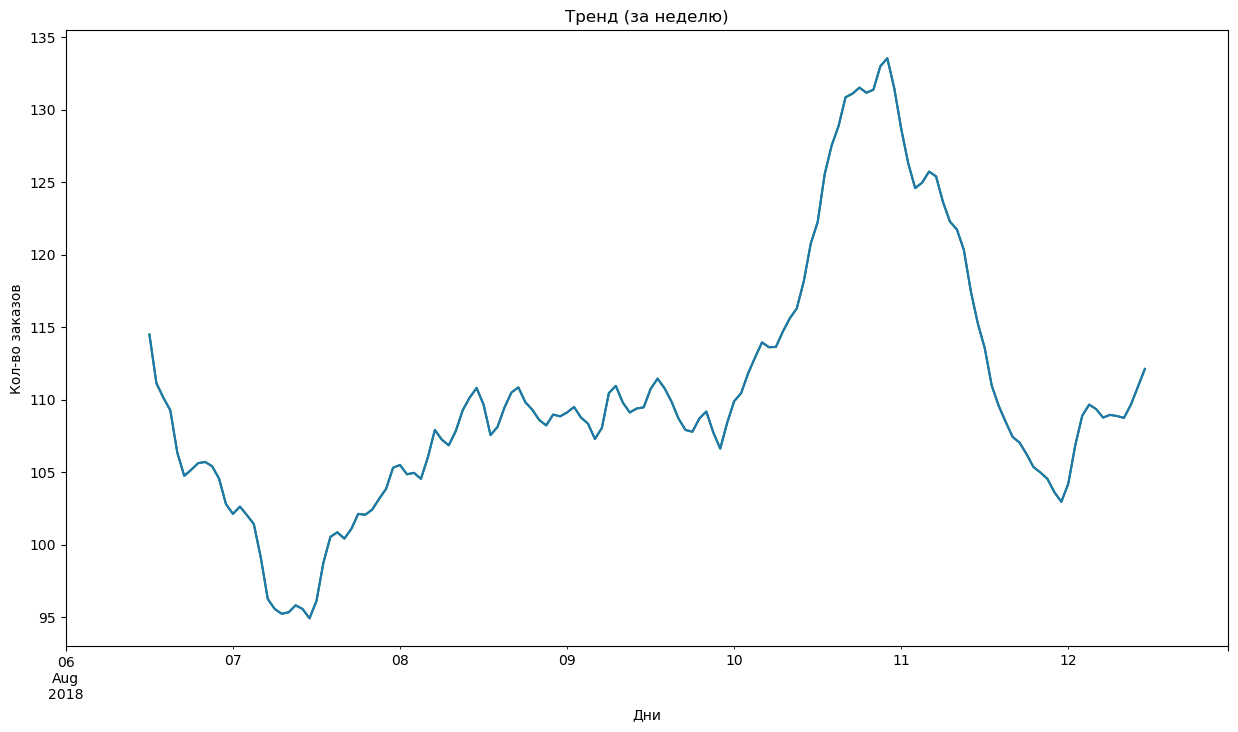

In [12]:
data_7d = data['2018-08-06':'2018-08-12'].resample('1H').sum()
data_7d = seasonal_decompose(data_7d)
data_7d.trend.plot(figsize = (15, 8), color = 'green')
data_7d.trend.plot(title = 'Тренд (за неделю)')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

Видим пики в понедельник и начиная с вечера пятницы в субботу. То есть, больше всего заказов такси в аэропорт приходится на начало и конец рабочей недели.

Посмотрим, как изменяется число заказов такси в течение дня на примере 2-х дней:

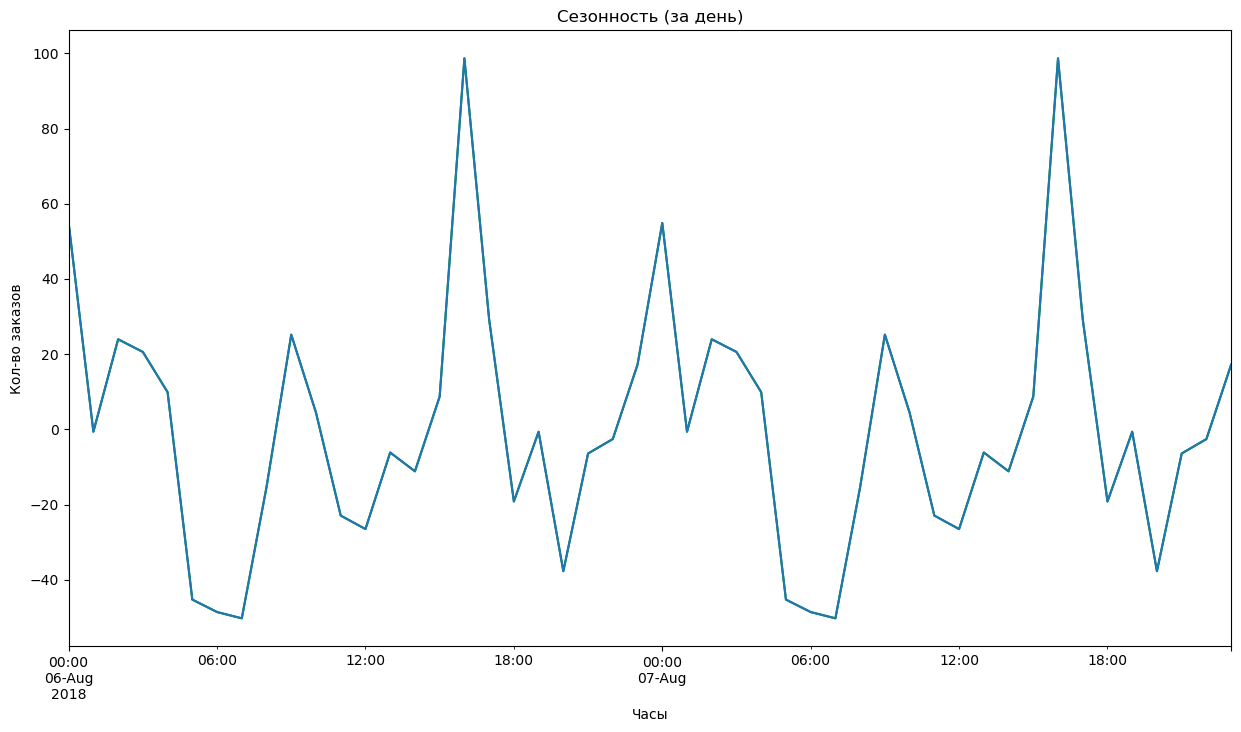

In [13]:
data_1h = data['2018-08-06':'2018-08-07'].resample('1H').sum()
data_1h = seasonal_decompose(data_1h)
data_1h.seasonal.plot(figsize = (15, 8), color = 'green')
data_1h.seasonal.plot(title = 'Сезонность (за день)')
plt.xlabel('Часы')
plt.ylabel('Кол-во заказов')
plt.show()

Видим увеличение кол-ва заказов с 23 до 4 часов и пики в 10, 11, 15 и 19 часов. Самое непопулярное время - 6 часов.

**Вывод:**

В этом разделе были проанализированы тренды за полугодовой период, за неделю и за день.

Выявлены следующее тенденции:

- На полугодовом периоде прослеживается рост числа заказов такси в аэропорт.
- Больше всего заказов такси в аэропорт приходится на понедельник и на субботу.
- Кол-во заказов увеличивается с 23 до 4 часов и в 10, 11, 15 и 19 часов, самое непопулярное время - 6 часов.

Данные подготовлены для обучения моделей.

<a id=4></a>
[Содержание](#0)
## 4. Обучение моделей

Обучим разные модели и подберем гиперпараметры.

Разделим данные на обучающую и тестовую выборки в соотношении 9:1.

Перемешивать выборки в задаче прогнозирования временного ряда нельзя, поэтому укажем аргумент shuffle (с англ. «перетасовывать») равным False, чтобы разделить данные корректно. Данные обучающей выборки должны предшествовать данным тестовой, чтобы не обучать модель на данных из будущего.

In [14]:
new_data.dropna(inplace = True)

new_data_x = new_data.drop('num_orders', axis = 1)
new_data_y = new_data['num_orders']

x_train, x_test, y_train, y_test = train_test_split(new_data_x, new_data_y,
                                             shuffle = False, test_size = 0.1)
print('Размер тренерующей выборки:', x_train.shape)
print('Размер тестовой выборки:', x_test.shape)

Размер тренерующей выборки: (3952, 5)
Размер тестовой выборки: (440, 5)


Зададим параметры для кроссвалидации:

In [15]:
kf = KFold(n_splits = 8, random_state = RND_STATE, shuffle = True)

n_splits, обычно, задают так, чтобы размер валидационной выборки при проведении кросс-валидации примерно совпадал с размером тестовой выборки. Размер тестовой выборки у нас 10%, а размер валидационной равен 1/(n_splits+1) части от обучающей выборки (согласно документации к TimeSeriesSplit).

При n_splits = 8 получаем: 1 / 9 * 90% = 10% - оптимальный выбор.

In [16]:
def fit_model(estimator, param_grid, x_train, y_train):
    model = GridSearchCV(estimator = estimator,
                         param_grid = param_grid,
                         n_jobs = -1,
                         cv = kf,
                         scoring = 'neg_root_mean_squared_error',
                        )

    model.fit(x_train, y_train)
    
    res = pd.DataFrame(model.cv_results_).iloc[model.best_index_]
    rmse = round(abs(model.cv_results_['mean_test_score'][model.best_index_]), 1)
    fit_time = round(res['mean_fit_time'], 3)
    score_time = round(res['mean_score_time'], 3)
    print()
    print("Лучший набор параметров:", model.best_params_)
    print('Лучшее значение RMSE:', rmse)
    print('Время обучения модели:', fit_time, 's')
    print('Время предсказания модели:', score_time, 's')
    print()

    scores_data.append([estimator, rmse, fit_time, score_time])

    return model.best_estimator_, model.best_score_

Сохраним результаты в таблицу scores_data:

In [17]:
scores_data = []

**4.1. LinearRegression** - линейная регрессия

In [18]:
%%time

lr_estimator = Pipeline([ ('lr', LinearRegression()) ])

scores = cross_val_score(lr_estimator, x_train, y_train,
                    scoring = 'neg_root_mean_squared_error', cv = kf)

rmse_lr = round(abs(scores.mean()), 1)
print('RMSE:', rmse_lr)

RMSE: 30.9
CPU times: user 47.4 ms, sys: 1.19 ms, total: 48.6 ms
Wall time: 15.4 ms


In [19]:
scores_data.append(['LinearRegression', rmse_lr, 15.4, 0.1])

**4.2. RandomForestRegressor** - регрессор случайный лес

In [20]:
%%time

rf_param_grid = {
    'max_depth': range(5, 12, 1),
    'n_estimators': range(50, 151, 10),
}

rf_best_model = fit_model(
    estimator = RandomForestRegressor(n_jobs = -1),
    param_grid = rf_param_grid,
    x_train = x_train,
    y_train = y_train
)


Лучший набор параметров: {'max_depth': 11, 'n_estimators': 110}
Лучшее значение RMSE: 23.1
Время обучения модели: 0.485 s
Время предсказания модели: 0.096 s

CPU times: user 1.41 s, sys: 334 ms, total: 1.74 s
Wall time: 28.6 s


**4.3. ExtraTreesRegressor** - регрессор лишних деревьев

In [21]:
%%time

rf_param_grid = {
    'max_depth': range(2, 21, 1),
    'n_estimators': range(50, 301, 50),
}

rf_best_model = fit_model(
    estimator = ExtraTreesRegressor(n_jobs = -1),
    param_grid = rf_param_grid,
    x_train = x_train,
    y_train = y_train
)


Лучший набор параметров: {'max_depth': 19, 'n_estimators': 150}
Лучшее значение RMSE: 22.6
Время обучения модели: 0.591 s
Время предсказания модели: 0.037 s

CPU times: user 1.57 s, sys: 313 ms, total: 1.88 s
Wall time: 41.6 s


**4.4. LGBMRegressor** - градиентный бустинг LGBMRegressor

In [22]:
%%time

lgbm_param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': range(4, 12, 1),
    'n_estimators': range(100, 301, 50),
}

lgbm_best_model = fit_model(
    estimator = LGBMRegressor(n_jobs = -1),
    param_grid = lgbm_param_grid,
    x_train = x_train,
    y_train = y_train
)


Лучший набор параметров: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200}
Лучшее значение RMSE: 21.8
Время обучения модели: 0.063 s
Время предсказания модели: 0.009 s

CPU times: user 2.1 s, sys: 581 ms, total: 2.68 s
Wall time: 6.88 s


**4.5. СatBoostRegressor** - градиентный бустинг CatBoostRegressor

In [23]:
%%time

catboost_param_grid = {
    'depth': range(2, 12, 1),
    'iterations': range(100, 301, 50),
    'learning_rate': [0.05, 0.1, 0.15],
}

catboost_best_model = fit_model(
    estimator = CatBoostRegressor(verbose = False),
    param_grid = catboost_param_grid,
    x_train = x_train,
    y_train = y_train
)


Лучший набор параметров: {'depth': 8, 'iterations': 300, 'learning_rate': 0.1}
Лучшее значение RMSE: 21.9
Время обучения модели: 0.776 s
Время предсказания модели: 0.003 s

CPU times: user 2.29 s, sys: 1.12 s, total: 3.4 s
Wall time: 1min 26s


Соберем полученные результаты по моделям в итоговую таблицу:

In [24]:
result = pd.DataFrame(scores_data)
result.columns = ['Model', 'RMSE', 'Fit_time', 'Score_time']
result.set_index('RMSE', inplace = True)
display(result.sort_values('RMSE'))

,Model,Fit_time,Score_time
RMSE,,,
21.8,LGBMRegressor(),0.063,0.009
21.9,<catboost.core.CatBoostRegressor object at 0x1...,0.776,0.003
22.6,ExtraTreesRegressor(n_jobs=-1),0.591,0.037
23.1,RandomForestRegressor(n_jobs=-1),0.485,0.096
30.9,LinearRegression,15.400,0.100


**Вывод:**

В этом разделе выполнено:

- Данные разделены на обучающую и тестовую выборки.
- Написана функция обучения моделей с выводом структурированного результата.
- Обучены пять моделей (Linear Regression, Random Forest, ExtraTreesRegressor, LightGBM и CatBoost) с различными гиперпараметрами.

Модель градиентного бустинга **LightGBM** показала наилучшую метрику оценки качества **RMSE = 21.8** и наименьшее время обучения.

По совокупности факторов, выберем лучшую модель **LightGBM** при следующих параметрах: learning_rate = 0.05, max_depth = 10, n_estimators = 200.

<a id=5></a>
[Содержание](#0)
## 5. Тестирование модели

Проверим качество лучшей модели **LightGBM** на тестовой выборке:

In [25]:
predicted = lgbm_best_model[0].predict(x_test)

rmse = mean_squared_error(y_test, predicted, squared = False)
print('Значение RMSE на тестовых данных:', rmse)

Значение RMSE на тестовых данных: 43.779597753414656


Наилучшая модель градиентного бустинга **LightGBM на тестовой выборке** имеет метрику оценки качества **RMSE = 43.77**.

Для тестовой выборки построим график сравнения истинных и предсказанных значений количества заказов от времени:

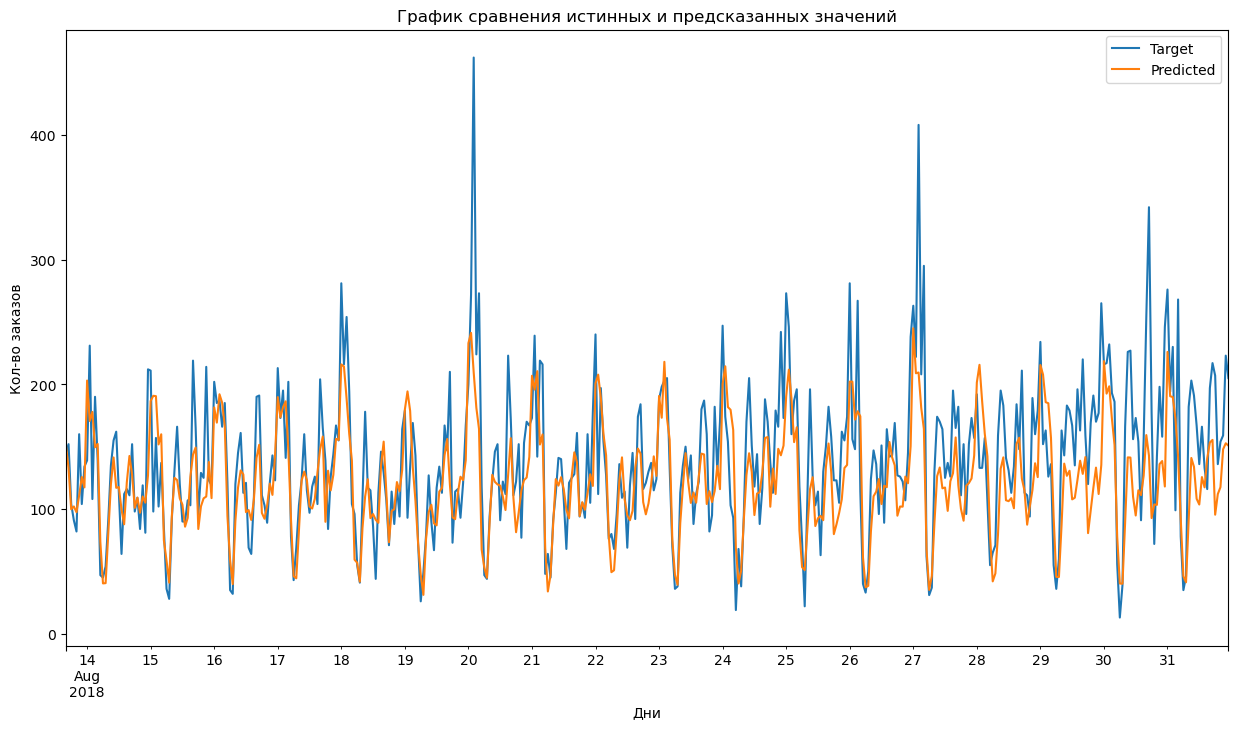

In [26]:
predicted = pd.Series(predicted, index = y_test.index)

plt.figure(figsize = (15, 8))
y_test.plot(label = 'Target')
predicted.plot(label = 'Predicted')
plt.legend()
plt.title('График сравнения истинных и предсказанных значений')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

На графике видно, что зависимости фактических и предсказанных значений количества заказов от времени имеют схожий характер.

**Вывод:**

В этом разделе были выполнено:

- Проверено качесто выбранной модели **LightGBM** на тестовой выборке.
- Для тестовой выборки построен график зависимости истинных и предсказанных значений количества заказов от времени.

В результате выявлено следующее:
- Наилучшая модель градиентного бустинга **LightGBM** на тестовой выборке имеет метрику оценки качества *RMSE = 43.77*
- Значение метрики *RMSE* на тестовой выборке не превышает *48*, что соответствует условиям задачи.

<a id=6></a>
[Содержание](#0)
## 6. Общий вывод

Проведено исследование с целью построения модели для предсказания количества заказов такси на следующий час.

Результаты исследования позволят привлечь больше водителей в периоды пиковой нагрузки.

Специалистам, занимающимся регулированием количества водителей в различные периоды нагрузки, можно использовать модель **LightGBM**.